# Preliminaries

## Re-generate the token table

The cell below uses Jupyter's "magic" commands to execute the whole first notebook and create `token_table.csv`.
- In the first line, we use `%%capture` to suppress all the messages that the first notebook normally would print to the screen. 
- In the second line, we use `%run` to run the whole notebook from start to finish.

This takes a little time. When it's done, the CSV file should appear.

In [1]:
%%capture
%run "03 - VF vs Seneca - Part 1.ipynb"

## Import statements

As usual, we need to import some functionality that isn't part of base Python. [**Pandas**](https://pandas.pydata.org/) and [**Matplotlib**](https://matplotlib.org/stable/index.html) are probably familiar by now. The third package, [**scikit-learn**](https://scikit-learn.org/stable/) is a machine-learning package that provides some very useful methods for dimensionality reduction and classification.

In [2]:
# provides functionality for tabular data
import pandas as pd

# provides plotting
from matplotlib import pyplot as plt

# dimensionality reduction
from sklearn.decomposition import PCA

## Load the data

This should load the token table from the CSV file and display it on the screen. **Note** I'm adding an extra step to force all the values to be read as text. This is because otherwise the **person** column tends to be read as numbers.

In [3]:
# load the token table
token_table = pd.read_csv('token_table.csv', dtype=str)

# show the results
display(token_table)

,urn,author,title,token,lemma,upos,mood,tense,voice,person,number,case,gender
0,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,Soror,soror,NOUN,NaN,NaN,NaN,NaN,Sing,Nom,Fem
1,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,Tonantis,Tonantis,NOUN,NaN,NaN,NaN,NaN,Sing,Gen,Masc
2,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,(,(,PUNCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,hoc,hic,DET,NaN,NaN,NaN,NaN,Sing,Acc,Neut
4,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,enim,enim,PART,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111319,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,tibi,tu,PRON,NaN,NaN,NaN,NaN,Sing,Dat,Masc
111320,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,praemia,praemium,NOUN,NaN,NaN,NaN,NaN,Plur,Acc,Neut
111321,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,reddi,reddo,VERB,NaN,Pres,Pass,NaN,NaN,NaN,NaN
111322,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,?,?,PUNCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature extraction

## Cleaning the data

As we did last time, here we create a new table leaving out any tokens labelled as punctuation.

In [6]:
no_punct = token_table.loc[token_table.upos!='PUNCT']

## Calculating lemma frequencies

### Feature tallies

Here we use the Pandas method `crosstab()` to create a feature frequency table. If we cross-tabulate **author** and **title**, on the one hand, against **lemma** on the other, then the resulting table has one row for each **author** - **title** pair, and one column for each possible value in **lemma**. The values tell us how many times each lemma occurs in each text.

### Normalization

As we did last time, we're going to normalize our counts by dividing by the length of each text. That gives us frequencies instead of raw tallies, making the texts more easily comparable.

Because the resulting frequencies are often very low, we're going to follow standard practice in stylometry and multiple them all by 1000. That means that values represent the expected count for a given feature in a sample of 1000 words.

The code below produces a table with one column for every possible lemma.

In [7]:
# tally lemma counts and normalize
lemma_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct.lemma, normalize='index')

# multiply by 1000
lemma_freq = lemma_freq * 1000

# display the result
display(lemma_freq)

lemma                                 o  (h)arena        ):  -gestans  \
author   title                                                          
Seneca   Herc_Fur    0.000000  0.000000  0.000000  0.000000  0.000000   
         Herc_Oet    0.000000  0.000000  0.000000  0.000000  0.087773   
         Medea       0.000000  0.000000  0.175131  0.000000  0.000000   
         Oedipus     0.000000  0.000000  0.000000  0.000000  0.000000   
         Phaedra     0.000000  0.000000  0.000000  0.000000  0.000000   
         Phoenissae  0.000000  0.000000  0.000000  0.000000  0.000000   
         Thyestes    0.000000  0.000000  0.000000  0.157704  0.000000   
         Troades     0.000000  0.000000  0.000000  0.000000  0.000000   
Val_Flac Thebaid_01  0.168520  0.000000  0.337041  0.337041  0.000000   
         Thebaid_02  0.000000  0.000000  0.000000  0.000000  0.000000   
         Thebaid_03  0.194818  0.000000  0.194818  0.000000  0.000000   
         Thebaid_04  0.187336  0.000000  0.187336  0.187336  0.000000   
         Thebaid_05  0.000000  0.000000  0.000000  0.000000  0.000000   
         Thebaid_06  0.191241  0.000000  0.191241  0.000000  0.000000   
         Thebaid_07  0.213767  0.213767  0.000000  0.000000  0.000000   
         Thebaid_08  0.000000  0.000000  0.000000  0.000000  0.000000   

lemma                -triumphos        ..       ...      ....     .....  ...  \
author   title                                                           ...   
Seneca   Herc_Fur      0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Herc_Oet      0.087773  0.087773  0.000000  0.000000  0.000000  ...   
         Medea         0.000000  0.175131  0.000000  0.000000  0.000000  ...   
         Oedipus       0.000000  0.337667  0.000000  0.000000  0.000000  ...   
         Phaedra       0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Phoenissae    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Thyestes      0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Troades       0.000000  0.000000  0.000000  0.000000  0.000000  ...   
Val_Flac Thebaid_01    0.000000  0.000000  0.337041  0.000000  0.000000  ...   
         Thebaid_02    0.000000  0.000000  0.000000  0.213995  0.000000  ...   
         Thebaid_03    0.000000  0.000000  0.194818  0.000000  0.000000  ...   
         Thebaid_04    0.000000  0.000000  0.187336  0.000000  0.000000  ...   
         Thebaid_05    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
         Thebaid_06    0.000000  0.000000  0.191241  0.000000  0.191241  ...   
         Thebaid_07    0.000000  0.000000  0.213767  0.000000  0.000000  ...   
         Thebaid_08    0.000000  0.000000  0.299850  0.000000  0.000000  ...   

lemma                †peranti†  †profundis†  †pulchro†  †quaeat†     †quus  \
author   title                                                               
Seneca   Herc_Fur      0.00000     0.000000   0.000000  0.000000  0.000000   
         Herc_Oet      0.00000     0.000000   0.000000  0.000000  0.000000   
         Medea         0.00000     0.000000   0.000000  0.000000  0.000000   
         Oedipus       0.00000     0.000000   0.000000  0.000000  0.000000   
         Phaedra       0.00000     0.000000   0.000000  0.000000  0.000000   
         Phoenissae    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thyestes      0.00000     0.000000   0.000000  0.000000  0.000000   
         Troades       0.00000     0.000000   0.000000  0.000000  0.000000   
Val_Flac Thebaid_01    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_02    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_03    0.00000     0.000000   0.194818  0.000000  0.194818   
         Thebaid_04    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_05    0.00000     0.000000   0.000000  0.000000  0.000000   
         Thebaid_06    0.00000     0.191241   0.000000  0.000000  0.000000

But as we learned last time, many of these columns are unhelpful to us because they're dedicated to lemmata that occur very rarely in the corpus. Let's see if we can do some more precise shaping of this feature set based on overall frequency in the corpus.

### Overall counts

Let's calculate again the corpus-wide count for each lemma. These will allow us to order the lemmata by frequency and identify the **most frequent words** as well as **hapax legomena**.

In [8]:
# calculate corpus-wide counts for all lemmata
lemma_count = no_punct.lemma.value_counts()

### MFWs

What are the most frequent words in the corpus?

In [9]:
# select the top 25 lemmata
mwf = pd.DataFrame(lemma_count[:25])

display(mwf)

,count
lemma,
que,3052
et,2314
qui,1447
sum,1132
hic,1044
in,905
tu,765
non,703
ego,686


### Hapax legomena

As we saw last time, over half of the lemmata in this list have a count of 1: they are **hapax legomena** (i.e. ἅπαξ λεγόμενα, "said once").

In [10]:
# select only those lemmata that occur once
hapaxes = pd.DataFrame(lemma_count[lemma_count==1])

display(hapaxes)

,count
lemma,
germino,1
Priami,1
Bella,1
conversae,1
Laomedon,1
...,...
macs,1
profare,1
poscuntur,1


### Stoplist

A **stoplist** is a list of features we will exclude from our analysis. For this notebook, I'm somewhat arbitrarily going to create a lemma stoplist including all lemmata that occur fewer than 10 times in the corpus.

In [11]:
# identify the lemmata for which count is less than 10
lemma_stop = lemma_count.index.values[lemma_count<10]

# how many?
print(len(lemma_stop), 'lemmata to be excluded')

12679 lemmata to be excluded


### Revised lemma table

Let's redo the lemma table. After we calculate the frequencies, we drop all the columns that are in the stoplist. The data frame `drop()` method lets us drop rows or columns, so we specify that we're talking about columns here.

In [12]:
# tally lemma counts and normalize
lemma_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct.lemma, normalize='index')

# multiply by 1000
lemma_freq = lemma_freq * 1000

# reorder columns according to overall frequency
lemma_freq = lemma_freq[lemma_count.index.values]

# drop columns in the stoplist
lemma_freq = lemma_freq.drop(lemma_stop, axis='columns')

# display the result
display(lemma_freq)

lemma                      que         et        qui        sum        hic  \
author   title                                                               
Seneca   Herc_Fur    23.364486  22.845275  15.186916  14.148494  10.514019   
         Herc_Oet    16.940226  19.485649  16.501360  21.153340  11.322742   
         Medea       21.716287  21.190893  19.614711  18.563923  10.858144   
         Oedipus     21.104170  22.792504  12.662502  11.143002   6.922168   
         Phaedra     23.518086  23.105488  13.890799  13.478201   8.251960   
         Phoenissae  18.015854  20.898391  22.099448  23.540716  19.216911   
         Thyestes    20.501498  25.705725  15.928087  23.182463  13.877937   
         Troades     22.096235  24.422154  19.188836  16.281436  15.409216   
Val_Flac Thebaid_01  54.095046  28.985507  15.503876   4.718571   8.594540   
         Thebaid_02  61.844639  31.457308  10.271774   1.497967  10.913760   
         Thebaid_03  49.483733  28.443405  14.026885   3.311903   6.623807   
         Thebaid_04  42.150618  30.348445  12.738854   3.746722  10.116148   
         Thebaid_05  36.678343  25.757264  15.042242   3.502988  11.539254   
         Thebaid_06  50.870147  24.478868  14.151845   1.529929  11.091987   
         Thebaid_07  46.387345  24.796922  14.108593   7.481830  12.612227   
         Thebaid_08  45.577211  23.388306  10.794603   6.896552  10.194903   

lemma                       in         tu       non        ego        iam  \
author   title                                                              
Seneca   Herc_Fur     7.658359   7.268951  5.970924   7.139148   3.245067   
         Herc_Oet    11.234969  10.181691  8.601773  12.112701   5.705258   
         Medea        7.880911   8.756567  7.880911   6.479860   5.429072   
         Oedipus      8.779335   7.935168  8.441668   5.402668   4.052001   
         Phaedra      7.426764   9.764819  8.114427   5.638839   2.475588   
         Phoenissae  12.250781  12.250781  8.887821  11.770358   5.044439   
         Thyestes    12.143195   4.258003  9.462230   5.204226   5.204226   
         Troades      5.960169   6.977758  8.576828   5.378689   2.907399   
Val_Flac Thebaid_01  11.796427   9.437142  5.224132   6.740816   8.088979   
         Thebaid_02   9.415793   5.135887  8.131821   5.349882  11.983736   
         Thebaid_03   7.403078   4.480810  4.870446   5.260082   8.961621   
         Thebaid_04   8.804796   4.870738  4.683402   7.493443   9.554140   
         Thebaid_05   9.066557   8.036266  5.151453   4.739336   9.066557   
         Thebaid_06  11.283228   4.589788  8.032129   3.251100   7.267164   
         Thebaid_07  11.970928  13.681060  7.481830  13.894827   9.191962   
         Thebaid_08  11.994003  12.893553  8.395802   8.095952   9.295352   

lemma                ...      loco  propinquus     iecur  Phasidis     ualeo  \
author   title       ...                                                       
Seneca   Herc_Fur    ...  0.129803    0.129803  0.000000  0.000000  0.000000   
         Herc_Oet    ...  0.000000    0.000000  0.526639  0.000000  0.351093   
         Medea       ...  0.000000    0.000000  0.000000  0.000000  0.000000   
         Oedipus     ...  0.000000    0.168833  0.168833  0.000000  0.000000   
         Phaedra     ...  0.000000    0.000000  0.137533  0.000000  0.000000   
         Phoenissae  ...  0.000000    0.240211  0.240211  0.000000  0.480423   
         Thyestes    ...  0.000000    0.157704  0.157704  0.000000  0.157704   
         Troades     ...  0.145370    0.000000  0.000000  0.000000  0.000000   
Val_Flac Thebaid_01  ...  0.000000    0.168520  0.000000  0.337041  0.000000   
         Thebaid_02  ...  0.641986    0.000000  0.000000  0.000000  0.213995   
         Thebaid_03  ...  0.584454    0.584454  0.000000  0.389636  0.000000   
         Thebaid_04  ...  0.000000    0.000000  0.000000  0.187336  0.000000   
         Thebaid_05  ...  0.000000    0.206058  0.000000  0.412116  0.412116   
        

Much better! We only have 1400 features to deal with here, a 90% reduction from the initial table.

### Visualizing feature distributions

As we saw last time, we can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the distribution of a given feature across the corpus. This can be helpful when comparing classes, say, comparing the 8 books by Valerius Flaccus to the 8 plays by Seneca.

This is the code that we finished with last time. In the first lines, we select a feature and assign it to the variable `feat`: this must be the name of one of the columns in our frequency table. The remainder of the code draws and labels a graph comparing the distribution of that feature across the books of each author.

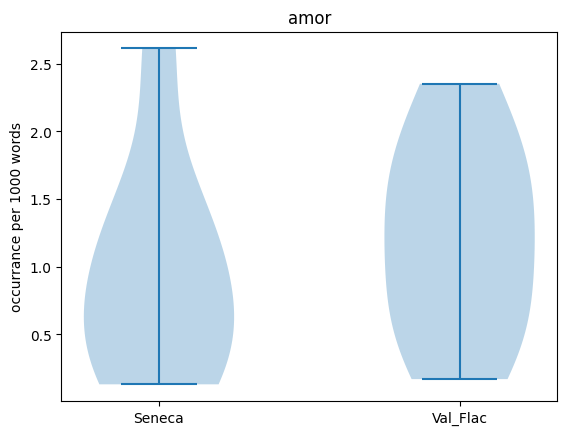

In [13]:
# feature of interest
feat = 'amor'

# create empty list for the labels and data values
labels = []
values = []

# extract labels, data from grouped table
for label, group in lemma_freq.groupby('author'):
    labels.append(label)
    values.append(group[feat])

# create a new plot
fig, ax = plt.subplots()

# plot the values
ax.violinplot(values)

# add labels
ax.set_xticks(range(1, len(labels)+1), labels=labels)
ax.set_ylabel('occurrance per 1000 words')
ax.set_title(feat)

# show
plt.show()

<div class="alert alert-success">
<h3>🤔 Explore the data</h3>

<p style="margin:1em 0em">Before continuing, try replacing <code>amor</code> above with various other lemmata of your choice. You can pick words that seem interesting to you, work through the MFWs listed above, or maybe try some of the words from Bernhard Söllradl's paper.</p>

<p style="margin:1em 0em">If you enter a word that doesn't have a column in the table, you'll get an error. Just pick another word and try again. Note that Patrick's trained language model tends to prefer 'u' over 'v', so for example <code>vir</code> doesn't work but <code>uir</code> does.</p>
    
<p style="margin:1em 0em"><strong>Which words show large differences between the two authors?</strong></p>
</div>

<hr>

# Basic clustering and classification

The next step in our experiment is to try **clustering** the data. This is a common task in stylometry and in data science generally. In the simplest terms, we're trying to spread out all the samples as widely as we can, and see whether they fall into distinct groups, or "clusters".

A related task is **classification**: deciding which group a given sample belongs to. If we have a mathematical model that defines the clusters, we can then use that model to classify an unknown sample.

For example, take a look at the distributions of the feature **que** using the code block above. Now, imagine we come across a text whose authorship is disputed. It uses *-que* at a rate of 22 times per 1000 words. Which of the two authors do you think is most likely to have written it?

## Visualizing multiple features at once

So far we've looked at one feature at a time. But we also know that several, perhaps many, of the lemmata differ between the two authors. Moreover, combining features may bring out information that we don't see otherwise.

Let's start by visualizing just two lemma frequencies at once... say **et** and **que**. We can plot these in a Cartesian space—that is, an x-y plot—with the frequency of **et** as the horizontal axis and that of **que** as the vertical. Each text then becomes a point on this graph, positioned according to its use of the two features.

The code below works much the same as the previous block: the two features of interest are set at the top; the remainder of the cell creates the graph. Drawing a **scatter plot** or x-y graph is really straightforward in Pyplot. Can you see more or less what's going on in each step?

💁🏻‍♂️ Hint: adding the `label=` option to `scatter()` registers the series with a given name. That's how Pyplot is able to create a legend at the end.

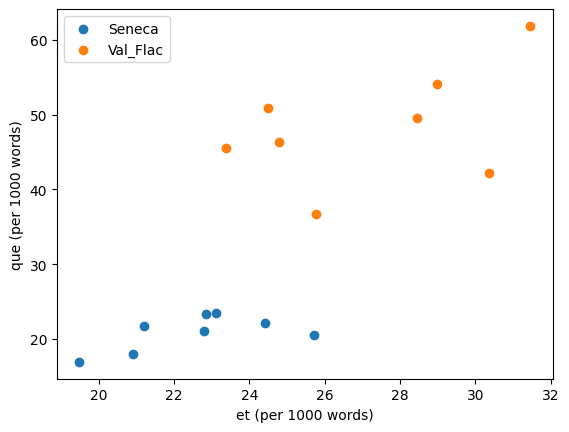

In [14]:
# features of interest
x_feat = 'et'
y_feat = 'que'

# create a new plot
fig, ax = plt.subplots()

# iterate over the authors
for label, group in lemma_freq.groupby('author'):
    
    # add a series points for this author
    ax.scatter(group[[x_feat]], group[[y_feat]], label=label)

# add figure labels and legend
ax.set_xlabel(x_feat + ' (per 1000 words)')
ax.set_ylabel(y_feat + ' (per 1000 words)')
ax.legend()

# show
plt.show()

<div class="alert alert-success">
<h3>🤔 Explore the data</h3>

<p style="margin:1em 0em">As before, try plugging in lemmata of your choice here to see the resulting graph. Do the two authors' texts separate out, or do they overlap? If you get good separation, see if you can formalize it for yourself: try writing out a set of rules for classifying the texts according to feature frequency.</p>
</div>

<hr>

# Dimensionality reduction

A scatterplot works well for representing exactly two features, but we have 1400 in our table. How can we visualize the data in a way that uses as much of the available information as possible? This is the problem of **dimensionality reduction**: reducing 1400 dimensions to 2, for example, so that we can draw a plot, while minimizing information loss.

## Principal Components Analysis

One common technique is **principal components analysis**, or **PCA**. This involves projecting data into a new *n*-dimensional space... where *n* is a more convenient number than 1400.

The new dimensions, called **principal components**, are essentially a rotation and stretching of the original dimensions. For example, PC1 might be calculated using a formula that multiplies each dimension by some weight, or coefficient. For example,

$$
0.002963 \times \textsf{que} + 0.000504 \times \textsf{et} + 0.002526 \times \textsf{qui} + \dots + w_i \times X_i
$$

where $w_i$ is the *i*th weight and $X_i$ is the *i*th dimension.

This transformation is calculated so that PC1 represents the greatest possible variance among the data points. The second PC is the dimension orthogonal to PC1 that shows the next greatest variance, and so on.

### Performing PCA using sklearn

Actually calculating these weights and then projecting the data into the new space is a complicated operation. A popular tool for this process is the **scikit-learn** package, aka **sklearn**. The cell below instantiates a new 2-dimensional PCA model and then transforms our data.

In [15]:
# calculate the principal components
pca_model = PCA(n_components=2)

# project the data into the lower-dimensional space 
pca_feats = pca_model.fit_transform(lemma_freq)

# turn the PCA feature set into a data frame
pca_feats = pd.DataFrame(pca_feats, columns=['PC1', 'PC2'])

### Plotting PCs

Now that our 1400 lemmata have been projected down to two dimensions, we can plot them on a scatter plot. Because the new 2-dimensional dataset is in a different table, we need to call back to the original table for the author labels.

The new dimensions do not have meaningful units; rather, the relative positions of and distance between the points are what we're looking at.

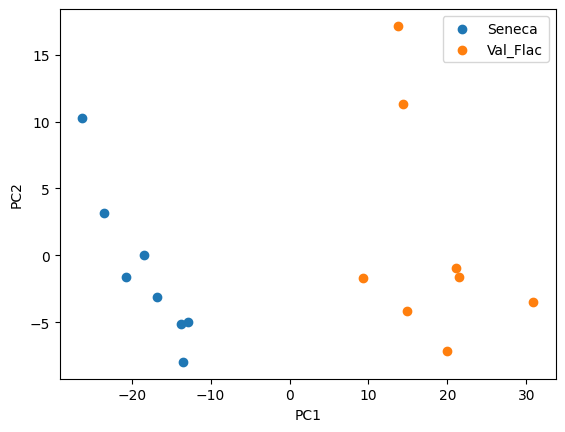

In [16]:
# create a new plot
fig, ax = plt.subplots()

# iterate over the authors
for label, group in pca_feats.groupby(lemma_freq.index.get_level_values('author')):
    
    # add a series points for this author
    ax.scatter(group.PC1, group.PC2, label=label)

# add figure labels and legend
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# show
plt.show()

# Integrating additional features

Besides lemmata, Bernhard also uses part-of-speech features like interjections, and grammatical features like mood and voice. We have these data in additional columns in our original token table. Here we extract those additional features and then put everything into a single feature frequency table.

## Part of speech

We'll extract part of speech frequencies, initially as a new table. We can combine the tables at the end. We use `crosstab()` here just as we did for lemmata above.

In [17]:
# tally pos counts and normalize
pos_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct.upos, normalize='index')

# multiply by 1000
pos_freq = pos_freq * 1000

# display the result
display(pos_freq)

upos                        ADJ        ADP        ADV        AUX       CCONJ  \
author   title                                                                 
Seneca   Herc_Fur    139.308012  27.705515  54.500520  14.438085   64.255983   
         Herc_Oet    116.631431  31.448203  63.072586  21.582100   53.646934   
         Medea       131.879726  29.013540  63.829787  18.990680   54.861966   
         Oedipus     132.915679  28.276329  57.060616  11.683034   61.293600   
         Phaedra     141.753999  24.958632  58.052951  13.789300   61.086597   
         Phoenissae  127.167630  32.996146  62.138728  24.566474   58.285164   
         Thyestes    130.861850  32.002535  59.252218  24.081115   63.529785   
         Troades     133.420822  23.476232  63.137941  16.477107   61.971420   
Val_Flac Thebaid_01  126.560918  37.968275  64.124198   4.724941  101.248734   
         Thebaid_02  113.349046  33.854725  67.495179   2.142704  106.492393   
         Thebaid_03  117.245416  34.139680  70.620367   3.316426   97.737027   
         Thebaid_04  116.135084  33.771107  90.806754   3.752345   96.060038   
         Thebaid_05  117.501546  35.868893  86.786230   3.710575   83.900227   
         Thebaid_06  121.979287  41.235136  73.839662   1.726122  102.416571   
         Thebaid_07  118.201285  40.685225  97.858672   8.351178   96.788009   
         Thebaid_08  112.777445  43.791242  90.281944   7.198560   95.980804   

upos                       DET      INTJ        NOUN       NUM       PART  \
author   title                                                              
Seneca   Herc_Fur    22.632674  4.032258  317.507804  3.511967   7.934443   
         Herc_Oet    28.188865  5.197322  296.071177  4.228330  11.539817   
         Medea       24.617549  2.461755  305.609284  4.747670   9.143661   
         Oedipus     20.995598  2.878429  331.357941  4.232983  11.175076   
         Phaedra     22.338665  6.480971  337.148373  2.757860   9.928296   
         Phoenissae  35.886320  1.445087  295.761079  4.094412  12.524085   
         Thyestes    25.982256  1.901141  305.449937  2.059569  13.466413   
         Troades     28.288131  3.207932  301.983085  4.957714  13.269175   
Val_Flac Thebaid_01  22.949713  3.881201  309.652379  2.362470   8.774890   
         Thebaid_02  29.569316  4.713949  319.477180  3.642597  11.356332   
         Thebaid_03  22.824815  4.682013  326.375341  2.536091   7.218104   
         Thebaid_04  27.392120  4.315197  304.315197  1.313321   6.754221   
         Thebaid_05  32.158318  2.061431  301.999588  2.267574   8.039579   
         Thebaid_06  30.878404  2.493287  301.112390  3.835827   9.973149   
         Thebaid_07  41.327623  3.854390  241.755889  4.068522  11.349036   
         Thebaid_08  40.791842  5.098980  276.844631  4.499100  11.997600   

upos                      PRON      PROPN      SCONJ        VERB         X  
author   title                                                              
Seneca   Herc_Fur    44.745057  36.810614  12.356920  250.130073  0.130073  
         Herc_Oet    60.517970  41.402396  16.649049  249.647639  0.176180  
         Medea       48.004220  32.882012  17.583963  256.022507  0.351679  
         Oedipus     43.007111  28.276329  10.836438  255.672198  0.338639  
         Phaedra     44.401544  27.027027  11.720905  238.141202  0.413679  
         Phoenissae  63.583815  15.414258  21.435453  244.701349  0.000000  
         Thyestes    47.053232  22.655260  16.476553  255.228137  0.000000  
         Troades     46.806649  50.306212  14.289880  238.116069  0.291630  
Val_Flac Thebaid_01  39.655754  50.455619  12.656092  213.972325  1.012487  
         Thebaid_02  28.283694  38.568674  12.856225  227.555175  0.642811  
         Thebaid_03  33.164261  39.211861   9.559110  230.589153  0.780336  
         Thebaid_04  35.459662  39.774859  10.318949  229.643527  0.187617  
         Thebaid_05  42.259328  47.206761  15.460730  220.573078  0.206143  
         Thebaid_

### Renaming columns

Something we might want to watch out for if we ultimately add all these tables together is possible overlap between column names. Off the top of my head, I can't imagine a specific example, but I want to make sure we don't end up with a column in the **mood** table that has the same name as a column in the **lemma** table. 

The easiest way to make sure that all the column labels are unique is to add a prefix derived from the table name. In the code below, I redo the frequency table, with an extra step to rename all the columns so that they start with `pos_`. 

In [18]:
# tally pos counts and normalize
pos_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct.upos, normalize='index')

# multiply by 1000
pos_freq = pos_freq * 1000

# rename columns with a prefix
pos_freq = pos_freq.rename(columns = lambda name: 'pos_' + name)

# display result
display(pos_freq)

upos                    pos_ADJ    pos_ADP    pos_ADV    pos_AUX   pos_CCONJ  \
author   title                                                                 
Seneca   Herc_Fur    139.308012  27.705515  54.500520  14.438085   64.255983   
         Herc_Oet    116.631431  31.448203  63.072586  21.582100   53.646934   
         Medea       131.879726  29.013540  63.829787  18.990680   54.861966   
         Oedipus     132.915679  28.276329  57.060616  11.683034   61.293600   
         Phaedra     141.753999  24.958632  58.052951  13.789300   61.086597   
         Phoenissae  127.167630  32.996146  62.138728  24.566474   58.285164   
         Thyestes    130.861850  32.002535  59.252218  24.081115   63.529785   
         Troades     133.420822  23.476232  63.137941  16.477107   61.971420   
Val_Flac Thebaid_01  126.560918  37.968275  64.124198   4.724941  101.248734   
         Thebaid_02  113.349046  33.854725  67.495179   2.142704  106.492393   
         Thebaid_03  117.245416  34.139680  70.620367   3.316426   97.737027   
         Thebaid_04  116.135084  33.771107  90.806754   3.752345   96.060038   
         Thebaid_05  117.501546  35.868893  86.786230   3.710575   83.900227   
         Thebaid_06  121.979287  41.235136  73.839662   1.726122  102.416571   
         Thebaid_07  118.201285  40.685225  97.858672   8.351178   96.788009   
         Thebaid_08  112.777445  43.791242  90.281944   7.198560   95.980804   

upos                   pos_DET  pos_INTJ    pos_NOUN   pos_NUM   pos_PART  \
author   title                                                              
Seneca   Herc_Fur    22.632674  4.032258  317.507804  3.511967   7.934443   
         Herc_Oet    28.188865  5.197322  296.071177  4.228330  11.539817   
         Medea       24.617549  2.461755  305.609284  4.747670   9.143661   
         Oedipus     20.995598  2.878429  331.357941  4.232983  11.175076   
         Phaedra     22.338665  6.480971  337.148373  2.757860   9.928296   
         Phoenissae  35.886320  1.445087  295.761079  4.094412  12.524085   
         Thyestes    25.982256  1.901141  305.449937  2.059569  13.466413   
         Troades     28.288131  3.207932  301.983085  4.957714  13.269175   
Val_Flac Thebaid_01  22.949713  3.881201  309.652379  2.362470   8.774890   
         Thebaid_02  29.569316  4.713949  319.477180  3.642597  11.356332   
         Thebaid_03  22.824815  4.682013  326.375341  2.536091   7.218104   
         Thebaid_04  27.392120  4.315197  304.315197  1.313321   6.754221   
         Thebaid_05  32.158318  2.061431  301.999588  2.267574   8.039579   
         Thebaid_06  30.878404  2.493287  301.112390  3.835827   9.973149   
         Thebaid_07  41.327623  3.854390  241.755889  4.068522  11.349036   
         Thebaid_08  40.791842  5.098980  276.844631  4.499100  11.997600   

upos                  pos_PRON  pos_PROPN  pos_SCONJ    pos_VERB     pos_X  
author   title                                                              
Seneca   Herc_Fur    44.745057  36.810614  12.356920  250.130073  0.130073  
         Herc_Oet    60.517970  41.402396  16.649049  249.647639  0.176180  
         Medea       48.004220  32.882012  17.583963  256.022507  0.351679  
         Oedipus     43.007111  28.276329  10.836438  255.672198  0.338639  
         Phaedra     44.401544  27.027027  11.720905  238.141202  0.413679  
         Phoenissae  63.583815  15.414258  21.435453  244.701349  0.000000  
         Thyestes    47.053232  22.655260  16.476553  255.228137  0.000000  
         Troades     46.806649  50.306212  14.289880  238.116069  0.291630  
Val_Flac Thebaid_01  39.655754  50.455619  12.656092  213.972325  1.012487  
         Thebaid_02  28.283694  38.568674  12.856225  227.555175  0.642811  
         Thebaid_03  33.164261  39.211861   9.559110  230.589153  0.780336  
         Thebaid_04  35.459662  39.774859  10.318949  229.643527  0.187617  
         Thebaid_05  42.259328  47.206761  15.460730  220.573078  0.206143  
         Thebaid_

## Morphological features

If you remember our last couple of notebooks, morphological features that we pulled from SpaCy's `morph` attribute are spread across several columns in the token table: **mood**, **voice**, **tense**, **person**, **number**, **gender**, and **case**. I could use the same technique to create an additional feature frequency table for each of these, but that's a lot of tables to manage individually.

Instead, working from the model of the part-of-speech table, I'm going to create a template that I can re-use in a **for loop** to generate all the tables at once.

In [19]:
# a list of columns to process
feature_names = ['mood', 'voice', 'tense', 'person', 'number', 'gender', 'case']

# an empty list to gather the resulting tables
morph_tables = []

# iterate over the columns, using `feat` as a stand-in for the current feature
for feat in feature_names:
    
    # tally feature counts and normalize
    this_freq = pd.crosstab([no_punct.author, no_punct.title], no_punct[feat], normalize='index')

    # multiply by 1000
    this_freq = this_freq * 1000

    # rename columns with a prefix
    this_freq = this_freq.rename(columns = lambda name: feat + '_' + name.upper())
    
    # add table to the list
    morph_tables.append(this_freq)
    
# join all the tables together
morph_freq = pd.concat(morph_tables, axis=1)
    
# show results
display(morph_freq)

mood_IMP    mood_IND    mood_SUB   voice_ACT  \
author   title                                                        
Seneca   Herc_Fur     88.458298  724.515586  187.026116  714.209402   
         Herc_Oet     78.091106  736.984816  184.924078  734.974656   
         Medea       116.201117  682.681564  201.117318  730.932203   
         Oedipus      80.042689  760.939168  159.018143  714.285714   
         Phaedra      86.397059  747.242647  166.360294  745.238095   
         Phoenissae  119.010819  686.244204  194.744977  752.515091   
         Thyestes     60.575968  703.078451  236.345581  731.381286   
         Troades      95.516569  725.146199  179.337232  748.120301   
Val_Flac Thebaid_01   51.246537  763.157895  185.595568  724.333064   
         Thebaid_02   49.612403  781.395349  168.992248  740.134745   
         Thebaid_03   55.555556  773.504274  170.940171  731.497418   
         Thebaid_04   61.475410  796.448087  142.076503  726.359833   
         Thebaid_05   56.360709  716.586151  227.053140  703.454894   
         Thebaid_06   43.103448  798.850575  158.045977  745.437956   
         Thebaid_07   65.088757  745.562130  189.349112  752.808989   
         Thebaid_08   57.815846  783.725910  158.458244  761.506276   

                     voice_PASS  tense_FUT  tense_PAST  tense_PQP  tense_PRES  \
author   title                                                                  
Seneca   Herc_Fur    285.790598  73.449729  304.635762   8.428657  613.485852   
         Herc_Oet    265.025344  84.362140  317.695473  11.522634  586.419753   
         Medea       269.067797  67.052980  290.562914  11.589404  630.794702   
         Oedipus     285.714286  55.684455  320.185615   6.960557  617.169374   
         Phaedra     254.761905  65.420561  281.708945  13.351135  639.519359   
         Phoenissae  247.484909  87.006961  259.860789  19.721578  633.410673   
         Thyestes    268.618714  69.868996  253.275109  10.189229  666.666667   
         Troades     251.879699  78.928313  312.816799  12.309920  595.944967   
Val_Flac Thebaid_01  275.666936  59.030837  340.969163  21.145374  578.854626   
         Thebaid_02  259.865255  45.696068  301.806589  27.630181  624.867163   
         Thebaid_03  268.502582  47.801147  344.168260  21.988528  586.042065   
         Thebaid_04  273.640167  59.546314  311.909263  17.958412  610.586011   
         Thebaid_05  296.545106  56.866953  311.158798  31.115880  600.858369   
         Thebaid_06  254.562044  54.026504  306.829766  29.561672  609.582059   
         Thebaid_07  247.191011  56.994819  263.212435  27.979275  651.813472   
         Thebaid_08  238.493724  54.263566  296.124031  15.503876  634.108527   

                       person_1  ...  gender_FEM  gender_MASC  gender_NEUT  \
author   title                   ...                                         
Seneca   Herc_Fur    137.320977  ...  328.287018   442.554956   229.158026   
         Herc_Oet    119.305857  ...  358.471074   446.723731   194.805195   
         Medea       155.307263  ...  338.358945   425.050739   236.590316   
         Oedipus     121.664888  ...  334.698335   440.622441   224.679225   
         Phaedra     126.838235  ...  339.128521   435.739437   225.132042   
         Phoenissae  225.656878  ...  336.224701   399.421727   264.353573   
         Thyestes    115.193644  ...  311.911804   445.012100   243.076096   
         Troades     122.807018  ...  321.563981   483.175355   195.260664   
Val_Flac Thebaid_01  105.263158  ...  332.779623   462.901440   204.318937   
         Thebaid_02   83.720930  ...  385.090909   405.090909   209.818182   
         Thebaid_03   88.319088  ...  352.539062   430.664062   216.796875   
         Thebaid_04   96.994536  ...  373.273370   418.567298   208.159332   
         Thebaid_05  130.434783  ...  333.677686   447.658402   218.663912   
         Thebaid_06   76.149425  ...  354.702245   449.397982   195.899772   
         Thebaid_07  109.467456  ... 

## Combining all the features

Now let's combine lemma, part-of-speech, and morphological features in a single feature table and re-do PCA. This will give us the most complete picture of the differences among our texts.

(Note that it is possible that some of the features are muddying the waters—more isn't always better. To get the very best separation, we would have to more carefully examine what each feature is contributing to the PCA and possibly eliminate some that are unhelpful.)

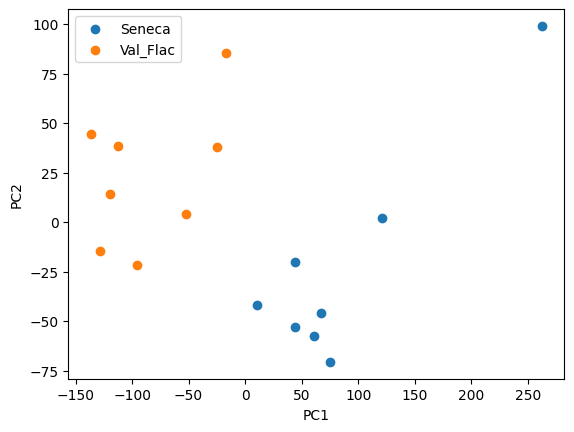

In [29]:
# combine all the tables
feat_freq = pd.concat([lemma_freq, pos_freq, morph_freq], axis=1)

# re-initialize the PCA model
pca_model = PCA(n_components=2)
pca_feats = pd.DataFrame(
    data = pca_model.fit_transform(feat_freq), 
    columns = ['PC1', 'PC2'], 
    index = feat_freq.index,
)

# create a new plot
fig, ax = plt.subplots()

# iterate over the authors
for label, group in pca_feats.groupby('author'):
    
    # add a series points for this author
    ax.scatter(group.PC1, group.PC2, label=label)

# add figure labels and legend
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# show
plt.show()

# Interpretation

## First impressions

Okay, we've thrown everything at the wall here... does anything seem to have stuck? What first impressions do we have of the results? What new questions are raised?

### Separation by author

For one thing, we've shown that authorship attribution with lexical features continues to be a pretty straightforward process. We can separate these 16 texts such that there is no overlap between the authors.

### Internal variance

At the same time, there is at least as much variation *within* the clusters as between them: the distance between the two most widely-separated orange dots is greater than the gap between the orange dots and the blue ones.

In general, the Valerius dots seem to be spread over a wider area than the Seneca dots. Does that make sense, given that Valerius' texts are books of a single epic, whereas Seneca's texts are standalone plays? 

### Outliers

In particular, one of the plays of Seneca is really far from everything else. What's going on there?

## From visualization back to close reading

One thing we can do is label the graph. Knowing the identity of the dots might help guide us in looking back at the text for some answers.

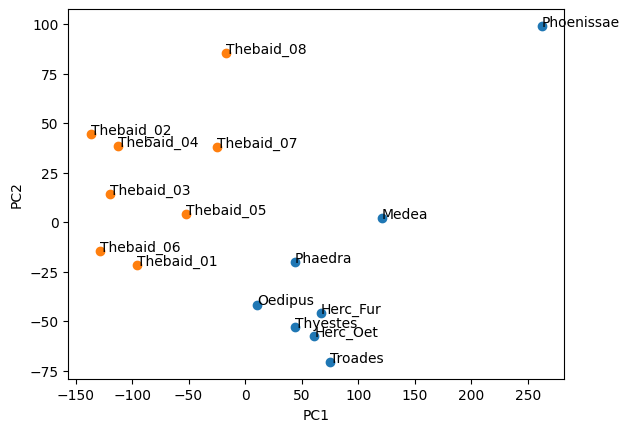

In [65]:
# create a new plot
fig, ax = plt.subplots()

# iterate over the authors
for label, group in pca_feats.groupby('author'):
    
    # add a series points for this author
    ax.scatter(group.PC1, group.PC2, label=label)

# add figure labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# add annotations for each dot
for row in pca_feats.itertuples():
    ax.text(row.PC1, row.PC2, row.Index[1])

# show
plt.show()